In [28]:
# Import required Libraries
# !pip install pyarrow
import math
import pandas_datareader as web
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import datetime

In [29]:
data = pd.read_parquet('https://github.com/ddkpham/Stock_Prediction_NLP_ML/blob/master/wsb.hourly.joined.parquet.gz?raw=true')

In [30]:
dataset = data.set_index('created_utc')
# dataset = dataset.values
dataset.head(5)

,score,gilded,wordcount,0,1,2,3,4,5,6,...,20,21,22,23,24,AAPL_StockPrice,AMZN_StockPrice,BA_StockPrice,SPY_StockPrice,TSLA_StockPrice
created_utc,,,,,,,,,,,,,,,,,,,,,
2017-01-03 00:00:00,10.600000,0.0,15.127273,-0.004773,0.096914,-0.028997,-0.013654,-0.040472,-0.028197,0.125876,...,0.034497,0.012236,0.022241,0.046725,-0.052190,116.01,757.76,155.68,224.86,214.3
2017-01-03 01:00:00,6.126761,0.0,14.957746,-0.018255,0.086793,-0.015693,-0.014463,-0.047337,-0.039189,0.151025,...,0.004107,0.018103,0.037762,0.030239,-0.058607,116.01,757.76,155.68,224.86,214.3
2017-01-03 02:00:00,5.150685,0.0,18.753425,-0.013361,0.085355,-0.045373,-0.029794,-0.013735,-0.030920,0.150325,...,-0.003617,0.002007,0.037377,0.017159,-0.064736,116.01,757.76,155.68,224.86,214.3
2017-01-03 03:00:00,5.723404,0.0,16.893617,-0.008933,0.079429,-0.009839,-0.026562,-0.041718,-0.015318,0.154539,...,-0.007581,0.005232,0.022578,0.016312,-0.054883,116.01,757.76,155.68,224.86,214.3
2017-01-03 04:00:00,1.516667,0.0,19.700000,-0.015290,0.079454,-0.002097,-0.019933,-0.023108,-0.015315,0.154939,...,-0.011684,0.011437,0.028106,0.017372,-0.061380,116.01,757.76,155.68,224.86,214.3


In [31]:
opening_price = data.filter(['created_utc','AAPL_StockPrice', 'AMZN_StockPrice', 
                                              'BA_StockPrice', 'SPY_StockPrice', 'TSLA_StockPrice'])
# Opening hour prices for stocks
opening_dataset = opening_price.set_index('created_utc')
opening_dataset = opening_dataset.resample('D').first().dropna(how='any')
opening_dataset = opening_dataset.values
print(len(opening_dataset))


713


In [32]:
# set training set len
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len
hours = data.filter(['created_utc'])
hours = hours['created_utc']
print(training_data_len)

# adjust training length to the end of a day since it may fall in the middle of a day
while(hours[training_data_len].hour != 0):
  training_data_len = training_data_len +1
print(training_data_len)
hours[training_data_len]

13618
13638


Timestamp('2019-04-12 00:00:00')

In [33]:
scaler = MinMaxScaler(feature_range=(0,1))
openScaler = MinMaxScaler(feature_range=(0,1))

scaled_dataset = scaler.fit_transform(dataset)

scaled_open_prices = openScaler.fit_transform(opening_dataset)
scaled_open_prices

array([[7.51032670e-05, 3.16376784e-03, 0.00000000e+00, 0.00000000e+00,
        1.69553372e-01],
       [4.50619602e-04, 0.00000000e+00, 4.51017411e-03, 4.79313824e-03,
        1.60795952e-01],
       [0.00000000e+00, 2.41568481e-03, 1.02790015e-02, 2.16952573e-02,
        2.29639000e-01],
       ...,
       [1.00000000e+00, 7.97604576e-01, 6.46877841e-01, 9.89404642e-01,
        7.20832928e-01],
       [9.60045062e-01, 7.86406708e-01, 6.72225718e-01, 9.88269425e-01,
        6.57438941e-01],
       [9.92790086e-01, 8.03098311e-01, 6.68170058e-01, 1.00000000e+00,
        6.59871558e-01]])

In [34]:
# Split date into x_train, y_train 
train_xvals = scaled_dataset[0:training_data_len, :]

# to check date of current row 
dates = data['created_utc']
t_data = data[data['created_utc'] < dates[training_data_len]]
training_days = t_data['created_utc'].dt.date.unique()

print(len(training_days))
print(training_days[-1]) # verify this is the correct date. Should be before the date in hours[training_data_len]



572
2019-04-11


In [35]:
x_train = []
y_train = []
i = 0
num_hours_in_day = 24
for idx in range(0,len(training_days)):
  time_step = []
  # last day in the list 
  if idx == len(training_days) - 1:
    while(i < training_data_len):
      hourly_data = train_xvals[i:i+1, :][0]
      time_step.append(hourly_data)
      i = i + 1
    while(len(time_step) < num_hours_in_day):
      filler = np.zeros(len(hourly_data))
      time_step.append(filler)
  else:
    # next_date = training_days['created_utc'][idx + 1]
    next_date = training_days[idx + 1]
    while(next_date > dates[i]):
    # day matches 
      hourly_data = train_xvals[i:i+1, :][0]
      time_step.append(hourly_data)
      i = i + 1
    # if there isnt a full 24 hours in set 
    while(len(time_step) < num_hours_in_day):
      filler = np.zeros(len(hourly_data))
      time_step.append(filler)
  time_step = np.array(time_step)
  
  time_step = np.reshape(time_step, (24,33))
  x_train.append(time_step)
  y_train.append(scaled_open_prices[idx+1].tolist())
  test_start_index = idx + 1
  if(idx < 2):
    print(y_train)
    # print('time_step',idx, time_step)


[[0.00045061960195269535, 0.0, 0.004510174113698251, 0.004793138244197692, 0.16079595212610687]]
[[0.00045061960195269535, 0.0, 0.004510174113698251, 0.004793138244197692, 0.16079595212610687], [0.0, 0.002415684807680285, 0.01027900146842875, 0.021695257315842653, 0.2296389997080861]]


In [36]:
# Convert both x, y training sets to np array 
x_train, y_train = np.array(x_train), np.array(y_train)
# Reshape the data // LSTM network expects 3 dimensional input in the form of 
# (number of samples, number of timesteps, number of features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 33))
x_train.shape

(572, 24, 33)

In [37]:
# Declare the LSTM model architecture 
model = Sequential()

# Add layers , input shape expected is (number of timesteps, number of features)
model.add(LSTM(75, return_sequences=True, input_shape=(x_train.shape[1], 33)))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(25))
model.add(Dropout(0.2))

model.add(Dense(5))

NotImplementedError: Cannot convert a symbolic Tensor (lstm_3/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
# Compile Model 
model.compile(optimizer='adam', loss='mean_squared_error')

In [118]:
# Train the model 
model.fit(x_train, y_train, batch_size=16, epochs=100)

Epoch 1/100
36/36 [==============================] - 1s 21ms/step - loss: 0.0312
Epoch 2/100
36/36 [==============================] - 1s 22ms/step - loss: 0.0068
Epoch 3/100
36/36 [==============================] - 1s 23ms/step - loss: 0.0036
Epoch 4/100
36/36 [==============================] - 1s 22ms/step - loss: 0.0024
Epoch 5/100
36/36 [==============================] - 1s 23ms/step - loss: 0.0019
Epoch 6/100
36/36 [==============================] - 1s 23ms/step - loss: 0.0013
Epoch 7/100
36/36 [==============================] - 1s 23ms/step - loss: 9.2413e-04
Epoch 8/100
36/36 [==============================] - 1s 23ms/step - loss: 8.3363e-04
Epoch 9/100
36/36 [==============================] - 1s 22ms/step - loss: 6.8969e-04
Epoch 10/100
36/36 [==============================] - 1s 22ms/step - loss: 6.2224e-04
Epoch 11/100
36/36 [==============================] - 1s 24ms/step - loss: 5.3550e-04
Epoch 12/100
36/36 [==============================] - 1s 23ms/step - loss: 4.2802e-04
E

In [152]:
test_x = scaled_dataset[training_data_len - 24:, :]
scaled_open_prices_test = scaled_open_prices[len(training_days):, :]
print(len(scaled_open_prices_test))
print(len(training_days))
print(len(scaled_open_prices))

stock_dates = data['created_utc']
days_after_training = data[data['created_utc'] >= stock_dates[training_data_len]]
testing_days = days_after_training['created_utc'].dt.date.unique()
test_days = days_after_training.reset_index(drop=True)


141
572
713


In [153]:
x_test = []
y_test = []
num_hours_in_day = 24
i = 0

for idx in range(0, len(testing_days)):
  time_step = []
  if (idx == len(testing_days) -1):
    while(i < len(days_after_training) - 24):
      hourly_data = test_x[i:i+1,:][0]
      time_step.append(hourly_data)
      i = i + 1
    while(len(time_step) < num_hours_in_day):
      filler = np.zeros(len(hourly_data))
      time_step.append(filler)
  else:
    next_date = testing_days[idx]
    while(next_date > test_days['created_utc'][i]):
      hourly_data = test_x[i:i+1,:][0]
      time_step.append(hourly_data)
      i = i + 1
    while(len(time_step) < num_hours_in_day):
      filler = np.zeros(len(hourly_data))
      time_step.append(filler)
  time_step = np.array(time_step)
  time_step = np.reshape(time_step, (24,33))
  x_test.append(time_step)
  y_test.append(scaled_open_prices_test[idx].tolist())
  print('time_step',idx, time_step.shape, len(testing_days) -1)
  # if(idx < 2):
  #   print('time_step',idx, time_step)


ValueError: ignored

In [ ]:
# Convert the data into a np array
x_test = np.array(x_test)

# Reshape data into 3 dimensions ( num samples, timesteps, num features )
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 33))

In [ ]:
# Get the models predicted price values 
predictions = model.predict(x_test)

# Inverse transform 
predictions = openScaler.inverse_transform(predictions)

In [123]:
# Evaluate model with root mean square error (RMSE)
rmse = np.sqrt(np.mean((predictions-y_test)**2))
rmse

857.4320505849481

In [124]:
plotData = data.set_index('created_utc')
plotData = plotData.resample('D').first().dropna(how='any')
plotData
# This is so it graphs nicely with dates 
AAPL = plotData["AAPL_StockPrice"]
AAPL = AAPL.to_frame()
AMZN = plotData["AMZN_StockPrice"]
AMZN = AMZN.to_frame()
BA = plotData["BA_StockPrice"]
BA = BA.to_frame();
SPY = plotData["SPY_StockPrice"]
SPY = SPY.to_frame();
TSLA = plotData["TSLA_StockPrice"]
TSLA = TSLA.to_frame()

appleTest = AAPL[0:len(training_days)]
amazonTest = AMZN[0:len(training_days)]
boeTest = BA[0:len(training_days)]
spyTest = SPY[0:len(training_days)]
teslaTest = TSLA[0:len(training_days)]

appleValid = AAPL[len(training_days):]
amazonValid = AMZN[len(training_days):]
boeValid = BA[len(training_days):]
spyValid = SPY[len(training_days):]
teslaValid = TSLA[len(training_days):]
# print(appleValid)

print(len(appleValid), len(predictions))
appleValid['Predictions'] = predictions[:,:1]
amazonValid["Predictions"] = predictions[:,1:2]
boeValid['Predictions'] = predictions[:, 2:3]
spyValid["Predictions"] = predictions[:, 3:4]
teslaValid["Predictions"] = predictions[:, 4:5]


141 141


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

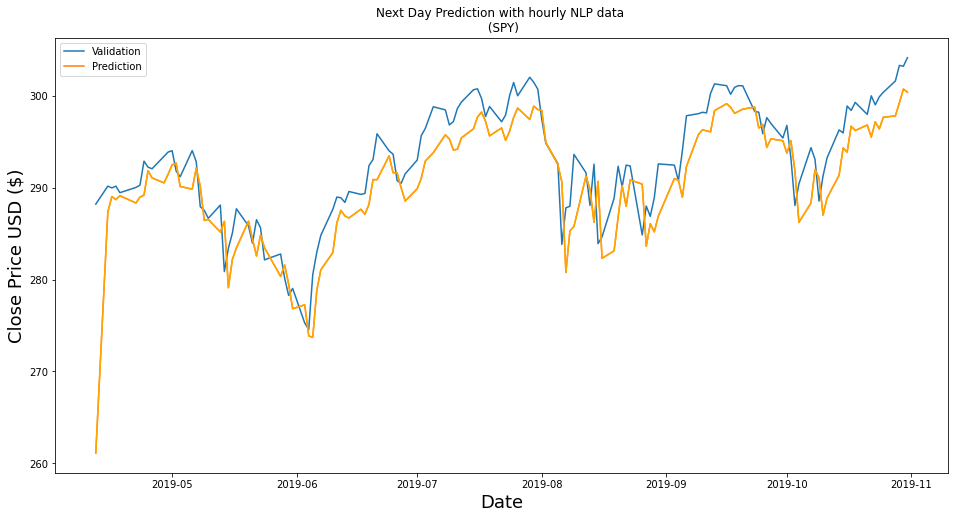

In [125]:
# Visualize data
plt.figure(figsize=(16,8))
plt.title('Next Day Prediction with hourly NLP data \n (SPY)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
# plt.plot(appleTest)
# plt.plot(appleValid)
# plt.plot(appleValid['Predictions'])
# plt.plot(amazonTest)
# plt.plot(amazonValid)
# plt.plot(amazonValid['Predictions'])
# plt.plot(boeTest)
# plt.plot(boeValid)
# plt.plot(boeValid['Predictions'])
# plt.plot(spyTest)
plt.plot(spyValid)
plt.plot(spyValid['Predictions'], color='orange')
# plt.plot(teslaTest)
# plt.plot(teslaValid)
# plt.plot(teslaValid['Predictions'])
plt.legend([ 'Validation', 'Prediction'])
plt.show()

In [126]:
# create dataset with hourly prices and no nlp data 
hour_data = data.filter(['created_utc','AAPL_StockPrice', 'AMZN_StockPrice', 
                                              'BA_StockPrice', 'SPY_StockPrice', 'TSLA_StockPrice'])
hour_data = hour_data.set_index('created_utc')
hour_data.head(5)

,AAPL_StockPrice,AMZN_StockPrice,BA_StockPrice,SPY_StockPrice,TSLA_StockPrice
created_utc,,,,,
2017-01-03 00:00:00,116.01,757.76,155.68,224.86,214.3
2017-01-03 01:00:00,116.01,757.76,155.68,224.86,214.3
2017-01-03 02:00:00,116.01,757.76,155.68,224.86,214.3
2017-01-03 03:00:00,116.01,757.76,155.68,224.86,214.3
2017-01-03 04:00:00,116.01,757.76,155.68,224.86,214.3


In [ ]:
hour_dataset = hour_data.values

In [128]:
train_len = math.ceil(len(hour_dataset) * 0.8)
train_len
hours = data.filter(['created_utc'])
hours = hours['created_utc']

# adjust training length to the end of a day since it may fall in the middle of a day
while(hours[train_len].hour != 0):
  train_len = train_len + 1
hours[train_len]

Timestamp('2019-04-12 00:00:00')

In [ ]:
hourScaler = MinMaxScaler(feature_range=(0,1))
priceScaler = MinMaxScaler(feature_range=(0,1))

scaled_hour_dataset = hourScaler.fit_transform(hour_dataset)
scaled_price_dataset = priceScaler.fit_transform(opening_dataset)

In [130]:
train_xvals2 = scaled_hour_dataset[0: train_len, :]

# to check date of current row 
dates = data['created_utc']
h_data = data[data['created_utc'] < dates[train_len]]
train_days = h_data['created_utc'].dt.date.unique()

print(len(train_days))
print(train_days[-1])

572
2019-04-11


In [131]:
x_train2 = []
y_train2 = []
j = 0
num_hours_in_day = 24
for idx in range(0,len(train_days)):
  time_step = []
  # last day in the list 
  if idx == len(train_days) - 1:
    while(j < train_len):
      hourly_data = train_xvals2[j:j+1, :][0]
      time_step.append(hourly_data)
      j = j + 1
    while(len(time_step) < num_hours_in_day):
      filler = np.zeros(len(hourly_data))
      time_step.append(filler)
  else:
    next_date = train_days[idx + 1]
    while(next_date > dates[j]):
    # day matches 
      hourly_data = train_xvals2[j:j+1, :][0]
      time_step.append(hourly_data)
      j = j + 1
    # if there isnt a full 24 hours in set 
    while(len(time_step) < num_hours_in_day):
      filler = np.zeros(len(hourly_data))
      time_step.append(filler)
  time_step = np.array(time_step)
  # print('time_step',idx, time_step)
  time_step = np.reshape(time_step, (24,5))
  x_train2.append(time_step)
  y_train2.append(scaled_open_prices[idx+1].tolist())
  test_start_index = idx + 1
  if(idx < 2):
    print(y_train)
    # print('time_step',idx, time_step)

[[4.50619602e-04 0.00000000e+00 4.51017411e-03 4.79313824e-03
  1.60795952e-01]
 [0.00000000e+00 2.41568481e-03 1.02790015e-02 2.16952573e-02
  2.29639000e-01]
 [4.80660909e-03 2.18190886e-02 1.29011957e-02 1.94248234e-02
  2.31098570e-01]
 ...
 [6.25084491e-01 8.42606446e-01 7.44108804e-01 7.87714430e-01
  4.54656028e-01]
 [6.37626737e-01 8.54560190e-01 7.30438431e-01 8.00075681e-01
  4.72657390e-01]
 [6.22230567e-01 8.45637741e-01 7.59282568e-01 7.99066599e-01
  4.35195096e-01]]
[[4.50619602e-04 0.00000000e+00 4.51017411e-03 4.79313824e-03
  1.60795952e-01]
 [0.00000000e+00 2.41568481e-03 1.02790015e-02 2.16952573e-02
  2.29639000e-01]
 [4.80660909e-03 2.18190886e-02 1.29011957e-02 1.94248234e-02
  2.31098570e-01]
 ...
 [6.25084491e-01 8.42606446e-01 7.44108804e-01 7.87714430e-01
  4.54656028e-01]
 [6.37626737e-01 8.54560190e-01 7.30438431e-01 8.00075681e-01
  4.72657390e-01]
 [6.22230567e-01 8.45637741e-01 7.59282568e-01 7.99066599e-01
  4.35195096e-01]]


In [132]:
# Convert both x, y training sets to np array 
x_train2, y_train2 = np.array(x_train2), np.array(y_train2)
# Reshape the data // LSTM network expects 3 dimensional input in the form of 
# (number of samples, number of timesteps, number of features)
x_train2 = np.reshape(x_train2, (x_train2.shape[0], x_train2.shape[1], 5))
x_train2.shape

(572, 24, 5)

In [ ]:
# Declare the LSTM model architecture 
model2 = Sequential()

# Add layers , input shape expected is (number of timesteps, number of features)
model2.add(LSTM(75, return_sequences=True, input_shape=(x_train2.shape[1], 5)))
model2.add(Dropout(0.2))

model2.add(LSTM(50, return_sequences=False))
model2.add(Dropout(0.2))

model2.add(Dense(25))
model2.add(Dropout(0.2))

model2.add(Dense(5))

In [ ]:
# Compile Model 
model2.compile(optimizer='adam', loss='mean_squared_error')

In [136]:
# Train the model 
model2.fit(x_train2, y_train2, batch_size=16, epochs=100)

Epoch 1/100
36/36 [==============================] - 1s 24ms/step - loss: 0.0602
Epoch 2/100
36/36 [==============================] - 1s 23ms/step - loss: 0.0250
Epoch 3/100
36/36 [==============================] - 1s 22ms/step - loss: 0.0218
Epoch 4/100
36/36 [==============================] - 1s 23ms/step - loss: 0.0187
Epoch 5/100
36/36 [==============================] - 1s 22ms/step - loss: 0.0170
Epoch 6/100
36/36 [==============================] - 1s 23ms/step - loss: 0.0170
Epoch 7/100
36/36 [==============================] - 1s 24ms/step - loss: 0.0143
Epoch 8/100
36/36 [==============================] - 1s 22ms/step - loss: 0.0143
Epoch 9/100
36/36 [==============================] - 1s 23ms/step - loss: 0.0124
Epoch 10/100
36/36 [==============================] - 1s 24ms/step - loss: 0.0114
Epoch 11/100
36/36 [==============================] - 1s 24ms/step - loss: 0.0108
Epoch 12/100
36/36 [==============================] - 1s 23ms/step - loss: 0.0103
Epoch 13/100
36/36 [=====

In [137]:
test_x2 = scaled_hour_dataset[train_len - 24:, :]
scaled_prices_test = scaled_price_dataset[len(train_days):, :]
print(len(scaled_prices_test))
print(len(train_days))
print(len(scaled_price_dataset))

stock_dates = data['created_utc']
after_training_data = data[data['created_utc'] >= stock_dates[train_len]]
testing_days2 = after_training_data['created_utc'].dt.date.unique()
test_days2 = after_training_data.reset_index(drop=True)

141
572
713


In [138]:
x_test2 = []
y_test2 = []
num_hours_in_day = 24
i = 0

for idx in range(0, len(testing_days2)):
  time_step = []
  if (idx == len(testing_days2) -1):
    while(i < len(after_training_data) - 24):
      hourly_data = test_x2[i:i+1,:][0]
      time_step.append(hourly_data)
      i = i + 1
    while(len(time_step) < num_hours_in_day):
      filler = np.zeros(len(hourly_data))
      time_step.append(filler)
  else:
    next_date = testing_days2[idx]
    while(next_date > test_days2['created_utc'][i]):
      hourly_data = test_x2[i:i+1,:][0]
      time_step.append(hourly_data)
      i = i + 1
    while(len(time_step) < num_hours_in_day):
      filler = np.zeros(len(hourly_data))
      time_step.append(filler)
  time_step = np.array(time_step)
  time_step = np.reshape(time_step, (24,5))
  x_test2.append(time_step)
  y_test2.append(scaled_prices_test[idx].tolist())
  print('time_step',idx, time_step.shape, len(testing_days) -1)
  # if(idx < 2):
  #   print('time_step',idx, time_step)

time_step 0 (24, 5) 140
time_step 1 (24, 5) 140
time_step 2 (24, 5) 140
time_step 3 (24, 5) 140
time_step 4 (24, 5) 140
time_step 5 (24, 5) 140
time_step 6 (24, 5) 140
time_step 7 (24, 5) 140
time_step 8 (24, 5) 140
time_step 9 (24, 5) 140
time_step 10 (24, 5) 140
time_step 11 (24, 5) 140
time_step 12 (24, 5) 140
time_step 13 (24, 5) 140
time_step 14 (24, 5) 140
time_step 15 (24, 5) 140
time_step 16 (24, 5) 140
time_step 17 (24, 5) 140
time_step 18 (24, 5) 140
time_step 19 (24, 5) 140
time_step 20 (24, 5) 140
time_step 21 (24, 5) 140
time_step 22 (24, 5) 140
time_step 23 (24, 5) 140
time_step 24 (24, 5) 140
time_step 25 (24, 5) 140
time_step 26 (24, 5) 140
time_step 27 (24, 5) 140
time_step 28 (24, 5) 140
time_step 29 (24, 5) 140
time_step 30 (24, 5) 140
time_step 31 (24, 5) 140
time_step 32 (24, 5) 140
time_step 33 (24, 5) 140
time_step 34 (24, 5) 140
time_step 35 (24, 5) 140
time_step 36 (24, 5) 140
time_step 37 (24, 5) 140
time_step 38 (24, 5) 140
time_step 39 (24, 5) 140
time_step 

In [ ]:
# Convert the data into a np array
x_test2 = np.array(x_test2)

# Reshape data into 3 dimensions ( num samples, timesteps, num features )
x_test2 = np.reshape(x_test2, (x_test2.shape[0], x_test2.shape[1], 5))

In [ ]:
# Get the models predicted price values 
predictions2 = model2.predict(x_test2)

# Inverse transform 
predictions2 = priceScaler.inverse_transform(predictions2)

In [142]:
# Evaluate model with root mean square error (RMSE)
rmse2 = np.sqrt(np.mean((predictions2-y_test2)**2))
rmse2

852.9317932274272

In [143]:
appleValid['Predictions2'] = predictions2[:,:1]
amazonValid["Predictions2"] = predictions2[:,1:2]
boeValid['Predictions2'] = predictions2[:, 2:3]
spyValid["Predictions2"] = predictions2[:, 3:4]
teslaValid["Predictions2"] = predictions2[:, 4:5]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

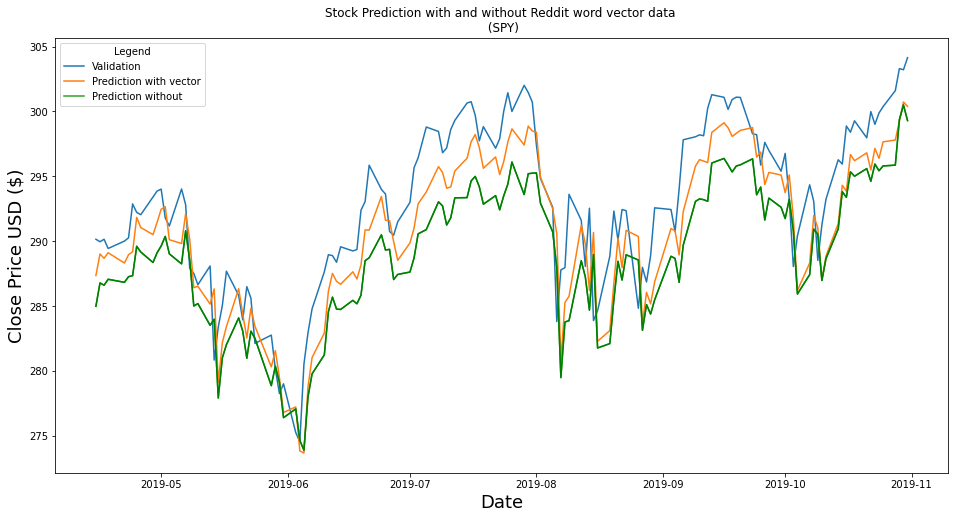

In [151]:
# Visualize data
plt.figure(figsize=(16,8))
plt.title('Stock Prediction with and without Reddit word vector data \n (SPY)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
# plt.plot(appleTest)
# plt.plot(appleValid)
# plt.plot(appleValid['Predictions'], color='red')
# plt.plot(appleValid['Predictions2'], color='green')
# plt.plot(amazonTest)
# plt.plot(amazonValid)
# plt.plot(amazonValid['Predictions'], color='red')
# plt.plot(amazonValid['Predictions2'], color='green')
# plt.plot(boeTest)
# plt.plot(boeValid)
# plt.plot(boeValid['Predictions'], color='red')
# plt.plot(boeValid['Predictions2'], color='green')
# plt.plot(spyTest, label='Train')
plt.plot(spyValid[1:], label='Actual')
# plt.plot(spyValid['Predictions'][1:], label='Prediction with vector', color='orange')
plt.plot(spyValid['Predictions2'][1:], label='Prediction without vector', color='green')

# plt.plot(teslaTest, label='Train')
# plt.plot(teslaValid, label="Actual")
# plt.plot(teslaValid['Predictions'], label="vector prediction", color='red')
# plt.plot(teslaValid['Predictions2'], label="without vector prediction", color="green")
plt.legend(('Validation', 'Prediction with vector', 'Prediction without'), title="Legend",)
plt.show()